In [1]:
# Загружаем инструменты для обработки данных
#
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import collections
from collections import Counter
import random
import re
import sys
import geopy.distance
from textblob import TextBlob, Blobber
from textblob.sentiments import NaiveBayesAnalyzer

# импортируем библиотеки для визуализации
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split
# Загружаем инструменты для кодирования
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, OneHotEncoder
from sklearn.feature_selection import f_classif
import category_encoders as ce
#
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
#
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

/kaggle/input/sf-booking/hotels_test.csv
/kaggle/input/sf-booking/hotels_train.csv
/kaggle/input/sf-booking/submission.csv


In [2]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [3]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

In [4]:
# Подгрузим наши данные из соревнования

DATA_DIR = '/kaggle/input/sf-booking/'
df_train = pd.read_csv(DATA_DIR+'/hotels_train.csv') # датасет для обучения
df_test = pd.read_csv(DATA_DIR+'hotels_test.csv') # датасет для предсказания
sample_submission = pd.read_csv(DATA_DIR+'/submission.csv') # submission

In [5]:
# для корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['reviewer_score'] = 0 # в тесте у нас нет значения reviewer_score, мы его должны предсказать, по этому пока просто заполняем нулями
#
data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем
##display(data)
data_base = data.copy()

In [6]:
display(data)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng,sample,reviewer_score
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.533137,9.171102,0,0.0
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,52.385649,4.834443,0,0.0
2,Mallorca 251 Eixample 08008 Barcelona Spain,46,11/26/2015,8.3,Alexandra Barcelona A DoubleTree by Hilton,Sweden,Pillows,3,351,Nice welcoming and service,5,15,"[' Business trip ', ' Solo traveler ', ' Twin ...",616 day,41.393192,2.161520,0,0.0
3,Piazza Della Repubblica 17 Central Station 201...,241,10/17/2015,9.1,Hotel Principe Di Savoia,United States of America,No Negative,0,1543,Everything including the nice upgrade The Hot...,27,9,"[' Leisure trip ', ' Couple ', ' Ambassador Ju...",656 day,45.479888,9.196298,0,0.0
4,Singel 303 309 Amsterdam City Center 1012 WJ A...,834,5/16/2016,9.1,Hotel Esther a,United Kingdom,No Negative,0,4687,Lovely hotel v welcoming staff,7,2,"[' Business trip ', ' Solo traveler ', ' Class...",444 day,52.370545,4.888644,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
515733,9 Knaresborough Place Kensington and Chelsea L...,107,4/19/2017,9.0,Hotel Moonlight,France,No Negative,0,617,Tr s proche du metro Earl s court,10,10,"[' Leisure trip ', ' Group ', ' Club Double or...",106 day,51.494028,-0.191050,1,8.8
515734,Landstra er Hauptstra e 155 03 Landstra e 1030...,272,2/13/2017,8.4,BEST WESTERN PLUS Amedia Wien,Turkey,No Negative,0,3224,The bed was so comfy I stayed with my boyfrie...,93,1,"[' Leisure trip ', ' Couple ', ' Standard Doub...",171 day,48.192379,16.399451,1,9.2
515735,29 31 Gower Street Camden London WC1E 6HG Unit...,457,2/7/2016,6.8,Bloomsbury Palace Hotel,Netherlands,room is really small but guess is normal in L...,12,2751,great location simple check in out nice shower,9,21,"[' Business trip ', ' Solo traveler ', ' Singl...",543 day,51.520795,-0.131084,1,8.3
515736,31 Great Cumberland Place Westminster Borough ...,365,5/21/2017,8.1,The Marble Arch London,United Arab Emirates,No Negative,0,1567,Location and very comfy bed,6,28,"[' Leisure trip ', ' Solo traveler ', ' Deluxe...",74 days,51.515125,-0.160066,1,9.2


#  Добавление новых числовых признаков

In [7]:
#преобразуем признак 'days_since_review' в числовой
data['days_since_review'] = data['days_since_review'].apply(lambda x: int(x.split()[0]))
data['days_since_review'].head()

0     13
1    234
2    616
3    656
4    444
Name: days_since_review, dtype: int64

In [8]:
#
#data['lat'] = data['lat'].fillna(0, inplace=True)
#data['lng'] = data['lng'].fillna(0, inplace=True)
#
# устанавливаем недостающие координаты местонахождения гостиниц через geopy
lat_nan_df = data[data['lat'].isnull()]
#
lat_nan_list = list(lat_nan_df.index) # список индексов строк, где lat = NaN
#
lng_nan_df = data[data['lng'].isnull()]
#
lng_nan_list = list(lng_nan_df.index) # список индексов строк, где lat = NaN
#
# списки lat_nan_list и lng_nan_list одни и теже
#
result=list(set(lat_nan_list) - set(lng_nan_list))  # result == 0
#
#    занести в data под номерами из списка lat_nan_list или из списка lng_nan_list
#    координаты отелей, соотв. координатам городов по месту нахождения
#
print(lat_nan_df['hotel_address'].nunique())                 # колич. уникальных элементов в столбце (всего 17)
hotel_address_lat_nan = lat_nan_df['hotel_address'].unique() # списока уникальных элементов в столбце
print(hotel_address_lat_nan)
#
cities_1 = []                       # список всех мест положений отелей с NaN координатами
for value in hotel_address_lat_nan:
    list_temp = value.split()
    cities_1.append(list_temp[len(list_temp)-2]) 
#
#print(cities_1)
#
def unique_elem_list(numbers): # находим только уникальные города расположения отелей
    unique = []
#
    for number in numbers:
        if number in unique:
            continue
        else:
            unique.append(number)
    return unique
uniq_cities_list = unique_elem_list(cities_1) # список уникальных городов ( всего 3 города)

17
['W hringer Stra e 33 35 09 Alsergrund 1090 Vienna Austria'
 'Gr nentorgasse 30 09 Alsergrund 1090 Vienna Austria'
 '23 Rue Damr mont 18th arr 75018 Paris France'
 'Josefst dter Stra e 10 12 08 Josefstadt 1080 Vienna Austria'
 'Taborstra e 8 A 02 Leopoldstadt 1020 Vienna Austria'
 'Josefst dter Stra e 22 08 Josefstadt 1080 Vienna Austria'
 'Bail n 4 6 Eixample 08010 Barcelona Spain'
 'Landstra er G rtel 5 03 Landstra e 1030 Vienna Austria'
 '4 rue de la P pini re 8th arr 75008 Paris France'
 '20 Rue De La Ga t 14th arr 75014 Paris France'
 'W hringer Stra e 12 09 Alsergrund 1090 Vienna Austria'
 'Savoyenstra e 2 16 Ottakring 1160 Vienna Austria'
 'Pau Clar s 122 Eixample 08009 Barcelona Spain'
 'Sieveringer Stra e 4 19 D bling 1190 Vienna Austria'
 'Paragonstra e 1 11 Simmering 1110 Vienna Austria'
 'Hasenauerstra e 12 19 D bling 1190 Vienna Austria'
 'Sep lveda 180 Eixample 08011 Barcelona Spain']


In [9]:
##data.info()

1. Недостающие координаты lat и lng для трех городов: Vienna, Paris, Barcelona. В них находятся
   17 отелей, в которых нет координат

In [10]:
#
# Действительные координаты городов расположения отелей с NaN координатами
# вручную подставляем координаты городов.
vienna_lat_lng    = [48.209,16.372]
paris_lat_lng     = [48.853, 2.348]
barcelona_lat_lng = [41.389, 2.159]
# создаем библиотеку из адресов NaN отелей и их координат для подстановки
coordinate_nan_hotels = {'W hringer Stra e 33 35 09 Alsergrund 1090 Vienna Austria': vienna_lat_lng,
                         'Gr nentorgasse 30 09 Alsergrund 1090 Vienna Austria': vienna_lat_lng,
                         '23 Rue Damr mont 18th arr 75018 Paris France': paris_lat_lng,
                         'Josefst dter Stra e 10 12 08 Josefstadt 1080 Vienna Austria': vienna_lat_lng,
                         'Taborstra e 8 A 02 Leopoldstadt 1020 Vienna Austria': vienna_lat_lng,
                         'Josefst dter Stra e 22 08 Josefstadt 1080 Vienna Austria': vienna_lat_lng,
                         'Bail n 4 6 Eixample 08010 Barcelona Spain': barcelona_lat_lng,
                         'Landstra er G rtel 5 03 Landstra e 1030 Vienna Austria': vienna_lat_lng,
                         '4 rue de la P pini re 8th arr 75008 Paris France': paris_lat_lng,
                         '20 Rue De La Ga t 14th arr 75014 Paris France': paris_lat_lng,
                         'W hringer Stra e 12 09 Alsergrund 1090 Vienna Austria': vienna_lat_lng,
                         'Savoyenstra e 2 16 Ottakring 1160 Vienna Austria': vienna_lat_lng,
                         'Pau Clar s 122 Eixample 08009 Barcelona Spain': barcelona_lat_lng,
                         'Sieveringer Stra e 4 19 D bling 1190 Vienna Austria': vienna_lat_lng,
                         'Paragonstra e 1 11 Simmering 1110 Vienna Austria': vienna_lat_lng,
                         'Hasenauerstra e 12 19 D bling 1190 Vienna Austria': vienna_lat_lng,
                         'Sep lveda 180 Eixample 08011 Barcelona Spain': barcelona_lat_lng}
#
hot_addr_list = data_base['hotel_address'].to_list()
#
for i,hotel_address in enumerate(hot_addr_list):
    if hotel_address in hotel_address_lat_nan:
        data['lat'][i] = coordinate_nan_hotels[hotel_address][0]
        data['lng'][i] = coordinate_nan_hotels[hotel_address][1]
#

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2. Страна
3. Город

   Находим из адреса

In [11]:
#display(hot_addr_list)
countries_1=[] # список стран нахождения каждого отеля
for value in hot_addr_list:
    list_temp = value.split()
    if list_temp[len(list_temp)-1] == 'Kingdom':
         temp_country = 'United Kingdom'
    else:
         temp_country = list_temp[len(list_temp)-1]
    countries_1.append(temp_country)
uniq_countries_list = unique_elem_list(countries_1) # список уникальных стран
print(len(countries_1),uniq_countries_list)
data['hotel_country'] = countries_1
#
##display(hot_addr_list)
cities_1=[] # список городов нахождения каждого отеля
for value in hot_addr_list:
    list_temp = value.split()
    if list_temp[len(list_temp)-2] == 'United':
         temp_city = 'London'
    else:
         temp_city = list_temp[len(list_temp)-2]
    cities_1.append(temp_city)
uniq_cities_list = unique_elem_list(cities_1) # список уникальных городов
print(len(cities_1),uniq_cities_list)
data['hotel_city'] = cities_1
# Каждой стране принадлежит только один город
#
display(data.groupby(['hotel_country', 'hotel_city']).count())
#
#
# Создание экземпляра класса OneHotEncoder()
ohe_enc = OneHotEncoder()
# Кодирование признака страны
ohe_hot_countries = ohe_enc.fit_transform(data[['hotel_country']])
#
ohe_data = pd.DataFrame(ohe_hot_countries.toarray(), columns=list(*ohe_enc.categories_))
data = pd.concat([data, ohe_data], axis=1)
#
# Кодирование признака города
##ohe_hot_cities = ohe_enc.fit_transform(data[['hotel_city']])
#
##ohe_data = pd.DataFrame(ohe_hot_cities.toarray(), columns=list(*ohe_enc.categories_))
##data = pd.concat([data, ohe_data], axis=1)





515738 ['Italy', 'Netherlands', 'Spain', 'United Kingdom', 'France', 'Austria']
515738 ['Milan', 'Amsterdam', 'Barcelona', 'London', 'Paris', 'Vienna']


,,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng,sample,reviewer_score
hotel_country,hotel_city,,,,,,,,,,,,,,,,,,
Austria,Vienna,38939,38939,38939,38939,38939,38939,38939,38939,38939,38939,38939,38939,38939,38939,38939,38939,38939,38939
France,Paris,59928,59928,59928,59928,59928,59928,59928,59928,59928,59928,59928,59928,59928,59928,59928,59928,59928,59928
Italy,Milan,37207,37207,37207,37207,37207,37207,37207,37207,37207,37207,37207,37207,37207,37207,37207,37207,37207,37207
Netherlands,Amsterdam,57214,57214,57214,57214,57214,57214,57214,57214,57214,57214,57214,57214,57214,57214,57214,57214,57214,57214
Spain,Barcelona,60149,60149,60149,60149,60149,60149,60149,60149,60149,60149,60149,60149,60149,60149,60149,60149,60149,60149
United Kingdom,London,262301,262301,262301,262301,262301,262301,262301,262301,262301,262301,262301,262301,262301,262301,262301,262301,262301,262301


Так как один город соответствует одной стране, то будем кодировать только признак страны, а город
не используем.

4. Национальность клиента.
   Создаем группы стран происхождения клиентов.

In [12]:
# .strip() - удаление пробелов в начале и в конце
data['reviewer_nationality'] = data['reviewer_nationality'].apply(lambda x: x.strip()) 
nationality_count = data["reviewer_nationality"].value_counts() # частота встречаемости каждой национальности
display(nationality_count)
#
# проанализируем страны, 
# из которых приезжают туристы и выделим общие группы:
#
united_kingdom = ['United Kingdom'] # группа туристов только из Великобритании
data['reviewer_uk'] = data['reviewer_nationality'].apply(
    lambda x: 1 if x in united_kingdom else 0)
# туристы из англоязычных стран кроме GB
english_list = ['United States of America', 
                'Australia', 
                'Canada', 
                'New Zealand',
                'India',
                ]
data['reviewer_en'] = data['reviewer_nationality'].apply(
    lambda x: 1 if x in english_list else 0)
#
# выделим мусульманские страны ближневосточного региона:
muslim_list = ['United Arab Emirates', 
               'Saudi Arabia', 
               'Turkey', 
               'Kuwait', 
               'Qatar', 
               'Oman']
data['reviewer_n_est'] = data['reviewer_nationality'].apply(
    lambda x: 1 if x in muslim_list else 0)
#страны СНГ
sng_list = ['Ukraine', 'Belarus', 'Moldova', 'Russia', 'Kazakhstan']
data['reviewer_sng'] = data['reviewer_nationality'].apply(
    lambda x: 1 if x in sng_list else 0)
#
# Страны Дальнего востока
china_list = ['Japan', 'China']
data['reviewer_china'] = data['reviewer_nationality'].apply(
    lambda x: 1 if x in china_list else 0)
# добавим признак резидентства туриста по отношению к стране, в которой находится отель:
data['reviewer_resident'] = data.apply(
    lambda row: 1 if row['reviewer_nationality'] == row['hotel_country'] else 0, axis=1)
#

United Kingdom              245246
United States of America     35437
Australia                    21686
Ireland                      14827
United Arab Emirates         10235
                             ...  
Comoros                          1
Anguilla                         1
Tuvalu                           1
Cape Verde                       1
Palau                            1
Name: reviewer_nationality, Length: 227, dtype: int64

 Визуализируем признаки национальности клиентов

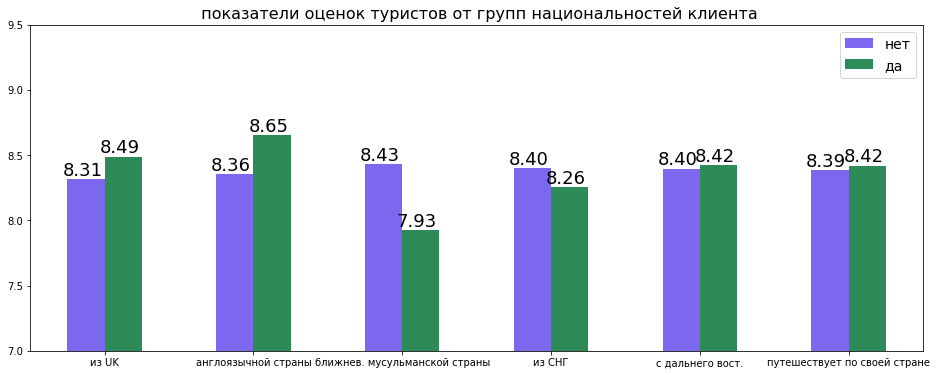

In [13]:
# подготовим данные для диаграммы:
mask = data['sample'] == 1
pivot_uk = data[mask].groupby('reviewer_uk')['reviewer_score'].mean()
pivot_en = data[mask].groupby('reviewer_en')['reviewer_score'].mean()
pivot_n_est = data[mask].groupby('reviewer_n_est')['reviewer_score'].mean()
pivot_sng = data[mask].groupby('reviewer_sng')['reviewer_score'].mean()
pivot_china = data[mask].groupby('reviewer_china')['reviewer_score'].mean()
pivot_resident = data[mask].groupby('reviewer_resident')['reviewer_score'].mean()
#
pivot = pd.DataFrame({
    'из UK': pivot_uk,
    'англоязычной страны': pivot_en,
    'ближнев. мусульманской страны': pivot_n_est,
    'из СНГ': pivot_sng,
    'с дальнего вост.': pivot_china,
    'путешествует по своей стране': pivot_resident 
}).T

# строим диаграмму:
fig2, ax2 = plt.subplots(figsize=(16, 6))
pivot_barplot = pivot.plot(
    ax=ax2, 
    kind='bar', 
    color=['mediumslateblue', 'seagreen'], 
    rot=0)
ax2.set_title(
    ' показатели оценок туристов от групп национальностей клиента', size=16)
ax2.legend(['нет', 'да'], loc='upper right', fontsize=14)
#
for p in pivot_barplot.patches:
    pivot_barplot.annotate('{:.2f}'.format(p.get_height()), (p.get_x()+0.1, p.get_height()),
    ha='center', va='bottom', fontsize=18)
#
plt.ylim(7, 9.5);

Синим цветом показаны оценки дпнной группы национальностей. Зеленым - оценки всех других национальностей. Туристы с дальнего востока и путешествующие по своей стране оценивают отели приблизительно как и остальные. Эти признаки, наверное, можно исключить ( так и получилось в итоге).

In [14]:

#
nation_list = data['reviewer_nationality'].to_list() # список стран проживания каждого клиента
#
uniq_nation_list = unique_elem_list(nation_list) # список уникальных национальностей
print(len(nation_list),len(uniq_nation_list))
#
counter = (collections.Counter(nation_list)) # словарь национальностей по частоте встречаемости
nation_dict = dict(counter)
##display(nation_dict)
# сортируем словарь национальностей по убыванию количества клиентов
#
nation_dict = {k: nation_dict[k] for k in sorted(nation_dict, key=nation_dict.get, reverse=True)}
#
##display(nation_dict)
# найдем первые по количеству 100 национальностей
i_1 = 1
short_nation_dict = {}
for j_1,key_1 in enumerate(nation_dict):
    if i_1 <=100:
           short_nation_dict[key_1] = nation_dict[key_1]
    else:
           break
    i_1 = i_1+1
#
keys_list = list(short_nation_dict.keys()) # список из ключей словаря short_nation_dict
print(keys_list)
for j_2,value_2 in enumerate(nation_list):
    if value_2 not in keys_list:
          data['reviewer_nationality'][j_2] = 'other'
#
# применим порядковое кодирование:
ord_enc = OrdinalEncoder()
# Кодирование признака
data['nation_100'] = ord_enc.fit_transform(data[['reviewer_nationality']])
#

515738 227
['United Kingdom', 'United States of America', 'Australia', 'Ireland', 'United Arab Emirates', 'Saudi Arabia', 'Netherlands', 'Switzerland', 'Germany', 'Canada', 'France', 'Israel', 'Italy', 'Belgium', 'Turkey', 'Kuwait', 'Spain', 'Romania', 'Russia', 'South Africa', 'India', 'Greece', 'China', 'Sweden', 'New Zealand', 'Singapore', 'Hong Kong', 'Poland', 'Qatar', 'Austria', 'Egypt', 'Norway', 'Czech Republic', 'Lebanon', 'Hungary', 'Malaysia', 'Thailand', 'Brazil', 'Portugal', 'Finland', 'Denmark', 'Malta', 'Bahrain', 'Indonesia', 'Cyprus', 'Luxembourg', 'Croatia', 'Oman', 'Bulgaria', 'Japan', 'Serbia', 'Ukraine', 'Iran', 'South Korea', 'Philippines', 'Nigeria', 'Iceland', 'Taiwan', 'Pakistan', 'Slovakia', 'Jersey', 'Slovenia', 'Estonia', 'Jordan', 'Lithuania', 'Latvia', 'Mexico', 'Guernsey', '', 'Argentina', 'Isle of Man', 'Gibraltar', 'Chile', 'Georgia', 'Iraq', 'Albania', 'Sri Lanka', 'Macedonia', 'Kazakhstan', 'Azerbaijan', 'Colombia', 'Kenya', 'Monaco', 'Bosnia and Herz

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


5. Year
6. Month

   Из признака 'review_date'

In [15]:
# получение year  и monyh из data
#
data['review_date']  = pd.to_datetime(data['review_date'])
data['review_year']  = data['review_date'].dt.year
data['review_month'] = data['review_date'].dt.month
data = data.drop(['review_date'],axis=1)
#data.head()

7. Количество дней в отеле, проведенные клиентом

   Из признака 'tags'

In [16]:
# создаем списки тегов для каждого отдельного клиента по числу строк в таблице
#
# tags_group_list список групп тегов (от каждого клиента по одной группе),группа - это строка, 
# состоящая из строк всех тегов от каждого клиента
#
tags_group_list_1 = data['tags'].values
tags_group_list = list(tags_group_list_1)
print('длина списка групп тегов', len(tags_group_list))
stayed_list = []
tags_list = []
tags_list_sum = []
i_1=0
tags_dict = {}
for tag_group in tags_group_list:
    tags = tag_group.split(', ')
    for tag in tags:
        clean_tag = re.sub(r'[\'\[\]]', '', tag)
        tags_list.append(clean_tag)
        tags_list_sum.append(clean_tag) # спмсок всех тэгов подряд как идут
    tags_list_1 = tags_list.copy()
    #
    # tags_dict словарь: key - порядковый номер клиента
    # значение - список тегов клиента
    tags_dict[i_1] = tags_list_1 
    tags_list.clear()  
    i_1=i_1+1
    #
#display(len(tags_dict),tags_dict)

длина списка групп тегов 515738


In [17]:
# создание списка количества дней stayed_list
#
stayed_list = []
for key_2 in tags_dict:
    j_2 = 0
    for str_2 in tags_dict[key_2]:
            if 'Stayed' in str_2 and j_2 ==0:
                list_temp = str_2.split()
                numb_2 = list_temp[1]
                stayed_list.append(numb_2)
                j_2 = 1
    if j_2 == 0:
        stayed_list.append('888')  # ставим 888, если дни пребывания не указаны
#
print(len(stayed_list))
len(tags_dict)
#
#  определяем самое частое количество дней пребывания
#
counts = Counter(stayed_list)
greatest = max(counts.values())
days_max = random.choice([item for item, count in counts.items() if count == greatest])
print('самое популярное количество дней пребывания',days_max)
#
stayed_list = [days_max if x == '888' else x for x in stayed_list] # замена '888' на '1'

#
data['stayed_days'] = stayed_list
data['stayed_days'] = pd.to_numeric(data['stayed_days']) # перевод строки в число в столбце dataframe
data['stayed_days'].replace({888: days_max}, inplace=True)


515738
самое популярное количество дней пребывания 1


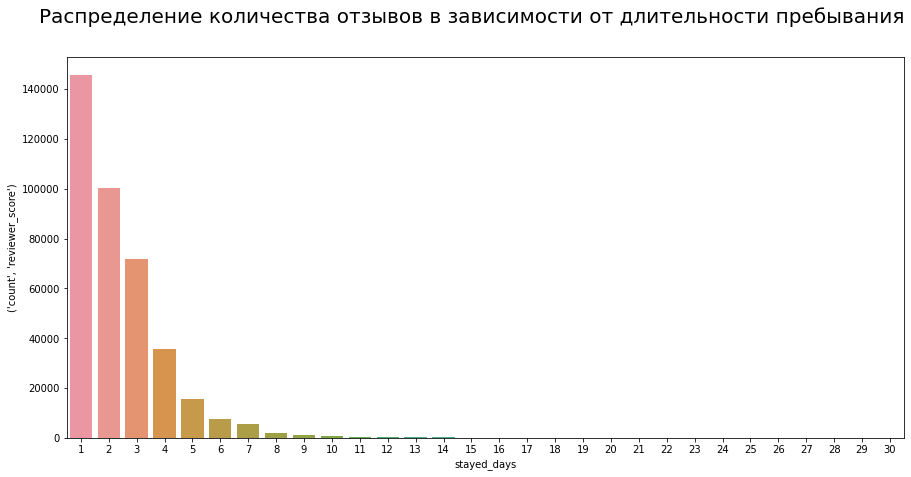

In [18]:
pivot_nights = pd.pivot_table(
    data[data['sample'] == 1], 
    index='stayed_days', 
    values='reviewer_score', 
    aggfunc=['count', 'mean'])
fig3, ax3 = plt.subplots(figsize=(15, 7))
plt.suptitle(
    'Распределение количества отзывов в зависимости от длительности пребывания', size=20)
sns.barplot(x=pivot_nights.index, y=pivot_nights[('count', 'reviewer_score')]);

Самое большое количество отзывов написано клиентами, останавливающимпеся 1-3 дня. Потом существенный спад. Таким образом видно, что этот признак значим, по крайней мере, для количества
отзывов и очень возможно существенно повлияет и на итоговую оценку.

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]


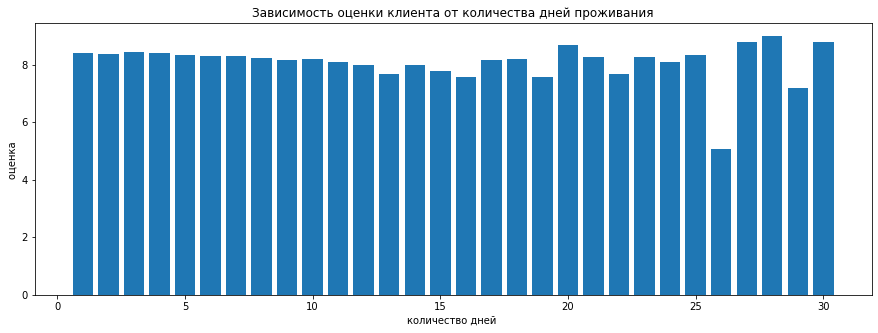

In [19]:
# график зависимости средней оценки клиентом отеля от количества дней проживания.
#

unique_stayed = list(set(stayed_list)) # получим уникальное количество дней проживания
unique_stayed_1 = []
for j_1, val_1 in enumerate(unique_stayed):
     temp = int(val_1)
     unique_stayed_1.append(temp)
     unique_stayed_1.sort()
print(unique_stayed_1)
#
score_mean_1 = []
#
for i_1, value_1 in enumerate(unique_stayed_1):
      temp_1 = data[(data['stayed_days']==value_1) & (data['sample']==1)].reviewer_score.mean()
      score_mean_1.append(temp_1)
# bar диаграмма (оценка от типа комнаты)
#
plt.figure(figsize=(15,5))
plt.bar(unique_stayed_1, score_mean_1)
plt.title("Зависимость оценки клиента от количества дней проживания")
plt.ylabel("оценка ")
plt.xlabel("количество дней ")
plt.show()
#

выходит, что люди, проживающие 1-3 дня славят подавляющее большинство оценок и эти оценки, как видно из диаграммы, стабильно >8. Т.о. признак 'stayed_days' скорее всего полезный.

8. создаем признаки из тегов:
                 1. тип путешествия
                 2. Состав путешественников

In [20]:
# списки для групп тэгов о типе путешествия
leisure_list     = []
business_list    = []
#
# списки для групп тэгов о составе путешественников
couple_list       = []
solo_list         = []
group_list        = []
fam_y_ch_list     = []
fam_o_ch_list     = []
sub_mob_dev_list  = []
trev_friends_list = []
#
ice_1 = 0
for key_4 in tags_dict:
    if ' Leisure trip '  in tags_dict[key_4]:
        leisure_list.append(1)
    else:
        leisure_list.append(0)
#
for key_4 in tags_dict:
    if ' Business trip '  in tags_dict[key_4]:
        business_list.append(1)
    else:
        business_list.append(0)
#
for key_4 in tags_dict:
    if ' Couple '  in tags_dict[key_4]:
        couple_list.append(1)
    else:
        couple_list.append(0)
#
for key_4 in tags_dict:
    if ' Solo traveler '  in tags_dict[key_4]:
        solo_list.append(1)
    else:
        solo_list.append(0)
#
for key_4 in tags_dict:
    if ' Group '  in tags_dict[key_4]:
        group_list.append(1)
    else:
        group_list.append(0)
#
for key_4 in tags_dict:
    if ' Travelers with friends '  in tags_dict[key_4]:
        trev_friends_list.append(1)
    else:
        trev_friends_list.append(0)
#
for key_4 in tags_dict:
    if ' Family with young children '  in tags_dict[key_4]:
        fam_y_ch_list.append(1)
    else:
        fam_y_ch_list.append(0)
#
for key_4 in tags_dict:
    if ' Family with older children '  in tags_dict[key_4]:
        fam_o_ch_list.append(1)
    else:
        fam_o_ch_list.append(0)
#
for key_4 in tags_dict:
    if ' Submitted from a mobile device '  in tags_dict[key_4]:
        sub_mob_dev_list.append(1)
    else:
        sub_mob_dev_list.append(0)
#  новые признаки (уже оцифрованные)
#
data['Leisure_trip']    = leisure_list
data['Business_trip']   = business_list
data['Couple']          = couple_list
data['Solo_traveler']   = solo_list
data['Group']           = group_list
data['Travelers with friends'] = trev_friends_list
data['Family_young_ch'] = fam_y_ch_list
data['Family_older_ch'] = fam_o_ch_list
data['Submit_mobile']   = sub_mob_dev_list
#
##    business_list.append(lambda x: 1 if ' Business trip ' in tags_dict[key_4] else 0)
##    couple_list.append(lambda x: 1   if ' Couple '        in tags_dict[key_4] else 0)
##    solo_list.append(lambda x: 1     if ' Solo traveler ' in tags_dict[key_4] else 0)
##    group_list.append(lambda x: 1    if ' Group '         in tags_dict[key_4] else 0)
##    fam_y_ch_list.append(lambda x: 1 if ' Family with young children ' in tags_dict[key_4] else 0)
##    fam_o_ch_list.append(lambda x: 1 if ' Family with older children ' in tags_dict[key_4] else 0)
#
##    data['Couple']          = (lambda x: 1 if ' Couple '        in tags_dict[key_4] else 0)
##    data['Solo_traveler']   = (lambda x: 1 if ' Solo traveler ' in tags_dict[key_4] else 0)
##    data['Group']           = (lambda x: 1 if ' Group '         in tags_dict[key_4] else 0)
##    data['Family_young_ch'] = (lambda x: 1 if ' Family with young children ' in tags_dict[key_4] else 0)
##    data['Family_older_ch'] = (lambda x: 1 if ' Family with older children ' in tags_dict[key_4] else 0)

Создание признаков на основании тегов, касающихся номеров отеля

In [21]:
# tags_all_dict - словарь, где key - это уникальный тэг, value - количество встречаемости тэга
tags_all_dict = dict.fromkeys(tags_list_sum, 0)
print('всего уникальных тэгов ',len(tags_all_dict))
#
for i_1,value_1 in enumerate(tags_list_sum):
    tags_all_dict[value_1] = tags_all_dict[value_1] +1
# сортируем словарь тегов tags_all_dict  по убыванию количества встречаемости
#
tags_all_dict = {k: tags_all_dict[k] for k in sorted(tags_all_dict, key=tags_all_dict.get, reverse=True)}
#
#
#
mask_2 = [' Leisure trip ',' Business trip ',' Couple ',' Solo traveler ',' Group ',\
          ' Travelers with friends ',' Family with young children ',' Family with older children ',\
          ' Submitted from a mobile device ']
# стремимся удалить все тэги, кроме касающихся номеров отелей
#
tags_all_dict_1 = tags_all_dict.copy() # оставляем словарь tags_all_dict в изначальном виде
for value_3 in mask_2:
    if value_3 in tags_all_dict:
        del tags_all_dict_1[value_3]
for i_3, key_3 in enumerate(tags_all_dict):
    if 'Stayed' in key_3:
        del tags_all_dict_1[key_3]
#display(tags_all_dict_1)
# теперь словарь tags_all_dict_1 включает в себя , в основном, только информацию о номерах
#
# соберем метки под характерные признаки номеров отелей
mask_3 = ['Standard','Superior','Deluxe','Classic','Single',\
          'Executive','Club','Queen','King','Premier','Suite','Triple','Double','2 rooms','Twin']
#
rooms_list = []
rooms_dict = {} # создаем словарь признаков номеров
j_4 = 0
for value_4 in mask_3:
      for i_4, key_4 in enumerate(tags_all_dict):
          if value_4 in key_4:
              rooms_list.append(key_4)
              if key_4 in tags_all_dict_1:
                 del tags_all_dict_1[key_4]
      rooms_list_1 = rooms_list.copy()
      rooms_dict[value_4] = rooms_list_1 # словарь: key - будущий признак; 
    #                                       value - тэги отелей, подходящих под этот признак
      rooms_list.clear()
#
# объединяем три последних признака и отправляем в Double
#
rooms_keys_list = list(rooms_dict.keys())
#
key_1 = rooms_keys_list[-1]
temp_list_1 = rooms_dict.get(key_1)
#
key_2 = rooms_keys_list[-2]
temp_list_2 = rooms_dict.get(key_2)
#
key_3 = rooms_keys_list[-3]
temp_list_3 = rooms_dict.get(key_3)
#
temp_list = temp_list_1 + temp_list_2 + temp_list_3
del rooms_dict['Double']
del rooms_dict['2 rooms']
del rooms_dict['Twin']
#
rooms_dict['Double'] = temp_list
#
# создаем list из оставшихся ключей словаря tags_all_dict_1
#
keys_list = list(tags_all_dict_1.keys())
rooms_dict['others'] = keys_list # последний признак формируем из оставшихся тэгов
#
print('всего уникальных тэгов после удаления всех меток, собранных в группы номеров отелей ',len(tags_all_dict_1))
#print(len(rooms_dict),rooms_dict)
#
##print(tags_all_dict_1)

   

всего уникальных тэгов  2428
всего уникальных тэгов после удаления всех меток, собранных в группы номеров отелей  232


In [22]:
# из словаря rooms_dict, в котором key - это будущие признаки, а value - списки соответствующих тегов
# создаем новые признаки по именам ключей
#
#
ii=0
len_tab_str = len(couple_list) # узнаем количество строк в твблице
temp_list_7 = []
while ii<=515737:
   temp_list_7.append(0)
   ii = ii + 1
print(len(temp_list_7))
temp_list_7_base = temp_list_7.copy()
#
for key_7 in rooms_dict:
    for str_7 in rooms_dict[key_7]:
        for num_guest in tags_dict:
            if str_7 in tags_dict[num_guest]:
                temp_list_7[num_guest] = 1
    if key_7 == 'Standard':
          data['Standard_room'] = temp_list_7
          temp_list_7.clear()
          temp_list_7 = temp_list_7_base.copy()
          print(key_7)
#  
    if key_7 == 'Superior':
          data['Superior_room'] = temp_list_7
          temp_list_7.clear()
          temp_list_7 = temp_list_7_base.copy()
          print(key_7)

# 
    if key_7 == 'Deluxe':
          data['Deluxe_room'] = temp_list_7
          temp_list_7.clear()
          temp_list_7 = temp_list_7_base.copy()
          print(key_7)
#
    if key_7 == 'Classic':
          data['Classic_room'] = temp_list_7
          temp_list_7.clear()
          temp_list_7 = temp_list_7_base.copy()
          print(key_7)
#
    if key_7 == 'Single':
          data['Single_room'] = temp_list_7
          temp_list_7.clear()
          temp_list_7 = temp_list_7_base.copy()
          print(key_7)
#
    if key_7 == 'Executive':
          data['Executive_room'] = temp_list_7
          temp_list_7.clear()
          temp_list_7 = temp_list_7_base.copy()
          print(key_7)
#
    if key_7 == 'Club':
          data['Club_room'] = temp_list_7
          temp_list_7.clear()
          temp_list_7 = temp_list_7_base.copy()
          print(key_7)
#
    if key_7 == 'Queen':
          data['Queen_room'] = temp_list_7
          temp_list_7.clear()
          temp_list_7 = temp_list_7_base.copy()
          print(key_7)
#
    if key_7 == 'King':
          data['King_room'] = temp_list_7
          temp_list_7.clear()
          temp_list_7 = temp_list_7_base.copy()
          print(key_7)
#
    if key_7 == 'Premier':
          data['Premier_room'] = temp_list_7
          temp_list_7.clear()
          temp_list_7 = temp_list_7_base.copy()
          print(key_7)
#
    if key_7 == 'Suite':
          data['Suite_room'] = temp_list_7
          temp_list_7.clear()
          temp_list_7 = temp_list_7_base.copy()
          print(key_7)
#
    if key_7 == 'Triple':
          data['Triple_room'] = temp_list_7
          temp_list_7.clear()
          temp_list_7 = temp_list_7_base.copy()
          print(key_7)
#
    if key_7 == 'Double':
          data['Double_room'] = temp_list_7
          temp_list_7.clear()
          temp_list_7 = temp_list_7_base.copy()
          print(key_7)
#
    if key_7 == 'others':
          data['others_room'] = temp_list_7
          temp_list_7.clear()
          temp_list_7 = temp_list_7_base.copy()
          print(key_7)
#

515738
Standard
Superior
Deluxe
Classic
Single
Executive
Club
Queen
King
Premier
Suite
Triple
Double
others


[8.177239347164113, 8.545186044710876, 8.473425013182817, 8.595181213017948, 8.011911220715351, 8.373695531501895, 8.414547275067916, 8.502716805382116, 8.662795636992483, 8.935364238410635, 8.558462732919585, 8.226497252747263, 8.386410730333747, 8.378470649712847]


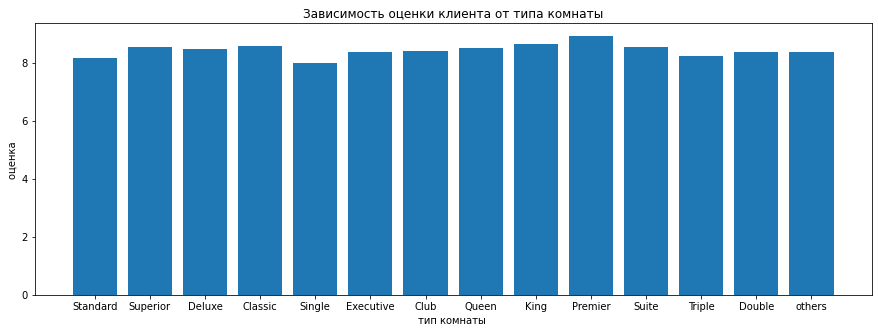

In [23]:
# график зависимости средней оценки клиентом отеля от группы номеров отеля.
score_mean = []
room_type = ['Standard_room', 'Superior_room','Deluxe_room','Classic_room','Single_room',\
             'Executive_room','Club_room',    'Queen_room', 'King_room',   'Premier_room',\
             'Suite_room',    'Triple_room',  'Double_room','others_room']
room_type_1 = ['Standard','Superior','Deluxe','Classic','Single','Executive','Club','Queen',\
               'King',    'Premier', 'Suite', 'Triple', 'Double','others']
#
for i_1, value_1 in enumerate(room_type):
      temp_1 = data[(data[value_1]==1) & (data['sample']==1)].reviewer_score.mean()
      score_mean.append(temp_1)
print(score_mean)
# bar диаграмма (оценка от типа комнаты)
#
plt.figure(figsize=(15,5))
plt.bar(room_type_1, score_mean)
plt.title("Зависимость оценки клиента от типа комнаты")
plt.ylabel("оценка ")
plt.xlabel("тип комнаты ")
plt.show()
#

С виду довольно бессмыссленное разделение получилось, но оставим как есть до момента оценки значимости.

9. Выделим признаки из названий отелей  'hotel_name'

In [24]:
# исследуем данные о названии на наличие дубликатов (разных отелей с одинаковым названием):
pivot_n = data[['hotel_address', 'hotel_name']].groupby(
    by='hotel_name'
).nunique()  # группируем отели по названиям с возможными разными адресами
#
# сводим в список индексы отелей с одним названием и с более чем 1 адресом
name_rep = pivot_n[pivot_n['hotel_address'] != 1].index.to_list()
mask = data['hotel_name'].isin(name_rep) # фильтр для дубликатов отелей по списку индексов
addresses_rep = data[mask][['hotel_name', 'hotel_address']].value_counts() # частота встречаемости дубликатов
#
print('Дублирование названия отеля:')
display(addresses_rep)
#
# чтобы различать эти отели при анализе - добавим в название город:
data['hotel_name'] = data.apply(
    lambda row: (row['hotel_name'] + ' ' + row['hotel_address'].split()[-2])
    if (row['hotel_name'] in name_rep)
    else row['hotel_name'], axis=1)

print('\nроверим полученные изменения:')
mask = data['hotel_name'].str.contains(name_rep[0])
display(data[mask]['hotel_name'].value_counts())

Дублирование названия отеля:


hotel_name    hotel_address                                             
Hotel Regina  Bergara 2 4 Eixample 08002 Barcelona Spain                    590
              Rooseveltplatz 15 09 Alsergrund 1090 Vienna Austria           284
              Via Cesare Correnti 13 Milan City Center 20123 Milan Italy     60
dtype: int64


роверим полученные изменения:


Hotel Regina Barcelona    590
Hotel Regina Vienna       284
Hotel Regina Milan         60
Name: hotel_name, dtype: int64

In [25]:
# всего количество уникальных отелей
#
print(data['hotel_name'].nunique()) # колич. уникальных имен отелей

1494


Всего отелей 1494, надо существенно уменьшить количество значимых отелей для анализа.
Используем только те, о которых много отзывов и высокая оценка.
  Выделим топ лучших по рейтингу (>9), с порогом в 100 отзывов:

In [26]:
# выделим топ лучших по рейтингу (>9), с порогом в 100 отзывов:
hotels_names = data.groupby('hotel_name')['average_score'].agg(
    ['mean', 'count']) # средняя оценка и количество оценок( равное количеству отзывов)
#
mask = (hotels_names['mean'] >= 9.0) & (hotels_names['count'] >= 100)
hotels_top = hotels_names[mask]
#
print('Лучшие по отзывам отели, имеющие минимум 100 отзывов:')
#
display(hotels_top)
#
data['hotel_top'] = data['hotel_name'].apply(
    lambda x: x if x in hotels_top.index else 'other') # новый признак с топовыми отелями и other
#
# применим порядковое кодирование:
ord_enc = OrdinalEncoder()
# Кодирование признака
data['hotel_top_ord'] = ord_enc.fit_transform(data[['hotel_top']])

Лучшие по отзывам отели, имеющие минимум 100 отзывов:


,mean,count
hotel_name,,
41,9.6,103
Acad mie H tel Saint Germain,9.0,255
Alma Barcelona GL,9.2,179
Amba Hotel Charing Cross,9.3,785
Ambassade Hotel,9.3,551
...,...,...
Waldorf Astoria Amsterdam,9.5,142
art otel Amsterdam,9.0,790
citizenM London Bankside,9.1,1517


In [27]:
#data.info(verbose=True, null_counts=True)

# Нормализация признаков

In [28]:
#проведем нормализацию для числовых признаков
num_cols = ['additional_number_of_scoring', 'average_score',
       'review_total_negative_word_counts', 'total_number_of_reviews',
       'review_total_positive_word_counts',
       'total_number_of_reviews_reviewer_has_given', 'lat',
       'lng','days_since_review']

In [29]:
import scipy.stats as stats

# задаём уровень значимости
alpha = 0.05 

# функция для принятия решения о нормальности
def decision_normality(p):
    print('p-value = {:.3f}'.format(p))
    if p <= alpha:
        print('p-значение меньше, чем заданный уровень значимости {:.2f}. Распределение отлично от нормального'.format(alpha))
    else:
        print('p-значение больше, чем заданный уровень значимости {:.2f}. Распределение является нормальным'.format(alpha))

In [30]:
#проверим распределение числовых признаков на нормальность с помощью теста Шапиро — Уилка

for col in num_cols:
    print('Признак ' + col)
    result = stats.shapiro(data[col])
    decision_normality(result[1])

Признак additional_number_of_scoring
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
Признак average_score
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
Признак review_total_negative_word_counts
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
Признак total_number_of_reviews
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
Признак review_total_positive_word_counts
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
Признак total_number_of_reviews_reviewer_has_given
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
Признак lat
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от норм

/opt/conda/lib/python3.7/site-packages/scipy/stats/morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
Признак days_since_review
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


In [31]:
from sklearn import preprocessing

# инициализируем нормализатор RobustScaler
r_scaler = preprocessing.RobustScaler()
# кодируем исходный датасет
data[num_cols] = r_scaler.fit_transform(data[num_cols])

10. Исследования текста отзывов клиентов с помощью анализатора TextBlob

In [32]:
#
# меняем метки отсутствия частей отзыва:
data['negative_review_temp'] = data['negative_review'].apply(
    lambda x: x.replace('No Negative', 'Positive'))
data['positive_review_temp'] = data['positive_review'].apply(
    lambda x: x.replace('No Positive', 'Negative'))
#
def get_polarity(text):
    """Получение параметра полярности отзыва"""
    blob = TextBlob(text)
    return blob.sentiment_assessments.polarity
#
# применяем TextBlob к временным столбцам для положительных и отрицательных отзывов
#
data['positive_polarity'] = data['positive_review_temp'].apply(get_polarity)
data['negative_polarity'] = data['negative_review_temp'].apply(get_polarity)

In [33]:
#
tb = Blobber(analyzer=NaiveBayesAnalyzer())
#
text_example = 'everything was great'
print(f'{tb(text_example).sentiment} для фразы "{text_example}"')
#
# так как позитивный и негативный компонент - взаимнообратные величины, образующие в сумме 1 - 
# можно ограничится только одним:
#
def get_blobber_sentiment(text):
    """Получение коэффициента позитивной оценки"""
    blobber_sentiment = tb(text).sentiment
    return blobber_sentiment[1]
#
data['positive_review_pos'] = data['positive_review_temp'].apply(get_blobber_sentiment)
data['negative_review_pos'] = data['negative_review_temp'].apply(get_blobber_sentiment)

Sentiment(classification='pos', p_pos=0.6252594845412645, p_neg=0.37474051545873566) для фразы "everything was great"


In [34]:
# добавим отзыву классификацию в зависимости от доли положительного компонента:
data['positive_review_class'] = data['positive_review_pos'].apply(
    lambda x: 1 if x >= 0.5 else 0)
data['negative_review_class'] = data['negative_review_pos'].apply(
    lambda x: 1 if x >= 0.5 else 0)
#
# добавляем параметр с классификацией отзыва:
def get_class(positive_review_class, negative_review_class):
    """Классификация отзыва, в зависимости от классов обеих частей"""
    if positive_review_class + negative_review_class == 2:
        return 10.0
    if positive_review_class == 1 and negative_review_class == 0:
        return 7.5
    if positive_review_class == 0 and negative_review_class == 1:
        return 5.0
    return 2.5
#
data['review_classification'] = data.apply(
    lambda row: get_class(row['positive_review_class'], row['negative_review_class']), 
    axis=1)

# Отбор признаков

In [35]:
# создаем дубликат базы для дальнейших манипуляций со столбцами (для обратимости экспериментов):
data_copy = data.copy()

  Собераем отдельно признаки числовые (float) и категориальные (int):

In [36]:
# убираем нечисловые признаки
object_columns = [s for s in data.columns if data[s].dtypes == 'object']
data.drop(object_columns, axis = 1, inplace=True)

In [37]:
# числовые признаки
#
numb_feat = ['additional_number_of_scoring', 'average_score',
             'review_total_negative_word_counts', 'total_number_of_reviews', 'review_total_positive_word_counts',
             'total_number_of_reviews_reviewer_has_given', 'days_since_review', 'lat', 'lng', 'reviewer_score',
             'positive_review_class', 'negative_review_class']
#
# категориальные признаки
#
cat_feat  = ['Austria', 'France', 'Italy', 'Netherlands', 'Spain', 'United Kingdom',
             'reviewer_uk', 'reviewer_en', 'reviewer_n_est', 'reviewer_sng', 'reviewer_china', 'reviewer_resident',
             'nation_100', 'hotel_top_ord', 'review_year', 'review_month', 'stayed_days', 'Leisure_trip', 'Business_trip', 
             'Couple', 'Solo_traveler', 'Group', 'Travelers with friends', 'Family_young_ch','Family_older_ch', 
             'Submit_mobile', 'Standard_room', 'Superior_room', 'Deluxe_room', 'Classic_room', 'Single_room',  
             'Executive_room', 'Club_room', 'Queen_room', 'King_room', 'Premier_room', 'Triple_room', 'Double_room', 
             'others_room']

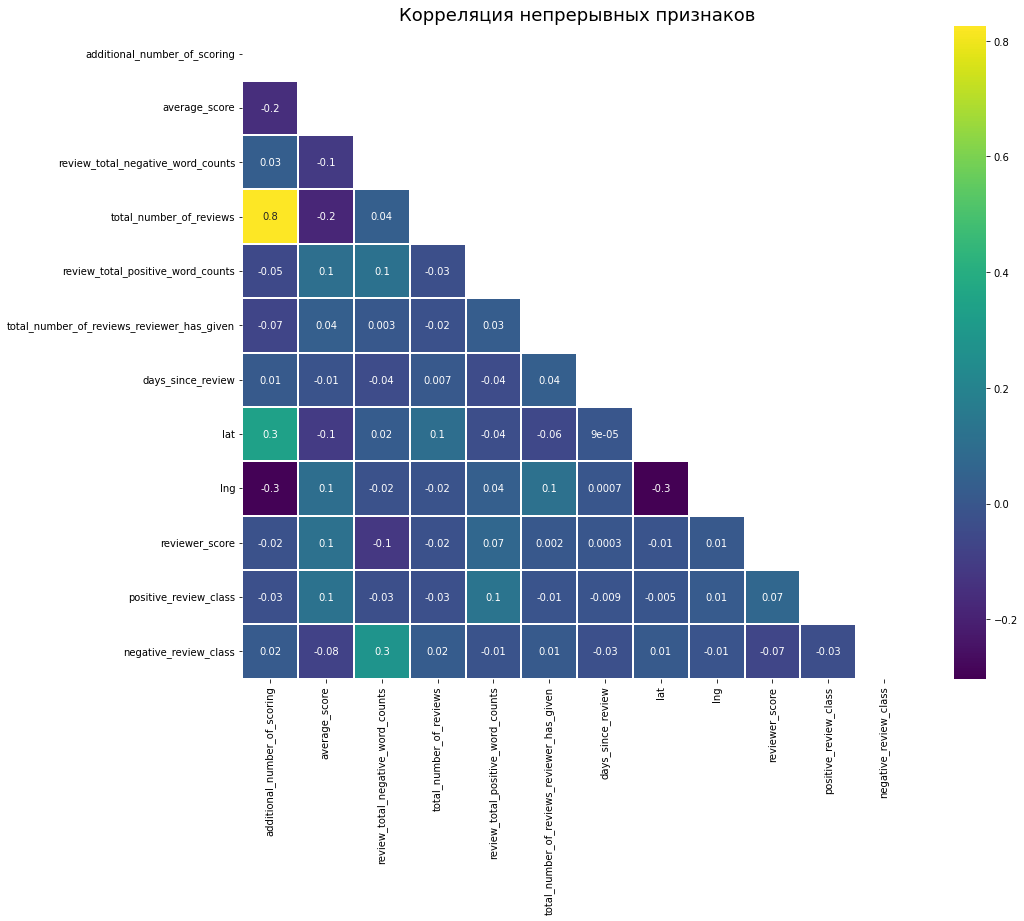

In [38]:
def show_corr_heatmap(columns_list, title, method):
    """Построения корреляционной диаграммы"""
    fig_, ax_ = plt.subplots(figsize=(15, 12))
    corr = data[columns_list].corr(method=method)
    mask = np.triu(np.ones_like(corr, dtype=bool))
    sns.heatmap(corr, 
                annot=True, 
                linewidths=0.1, 
                ax=ax_, 
                mask=mask, 
                cmap='viridis',
                fmt='.1g')
    ax_.set_title(title, fontsize=18)
    plt.show()
#
#строим диаграмму для непрерывных признаков:
show_corr_heatmap(numb_feat, 'Корреляция непрерывных признаков', method='pearson');

сильно коррелируют ( коэфф. корреляции 0.8) total_namber_of_reviews  и  additional_number_of scoring.  Удаляем один из них: additional_number_of scoring

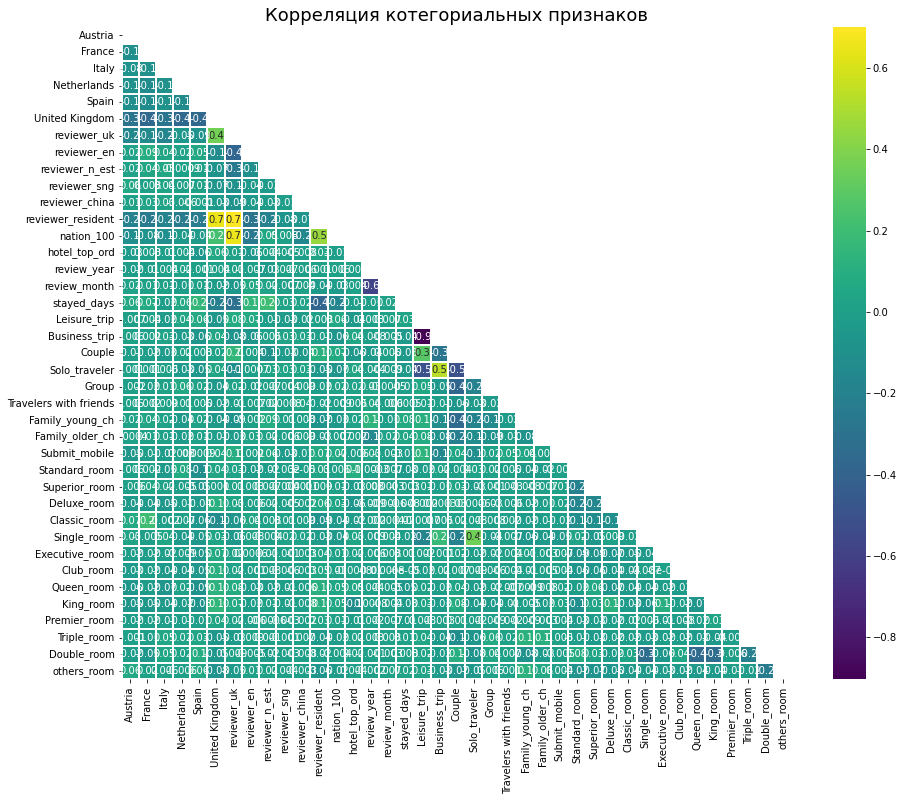

In [39]:
def show_corr_heatmap(columns_list, title, method):
    """Построения корреляционной диаграммы"""
    fig_, ax_ = plt.subplots(figsize=(15, 12))
    corr = data[columns_list].corr(method=method)
    mask = np.triu(np.ones_like(corr, dtype=bool))
    sns.heatmap(corr, 
                annot=True, 
                linewidths=0.1, 
                ax=ax_, 
                mask=mask, 
                cmap='viridis',
                fmt='.1g')
    ax_.set_title(title, fontsize=18)
    plt.show()
#
#строим диаграмму для непрерывных признаков:
show_corr_heatmap(cat_feat, 'Корреляция котегориальных признаков', method='pearson');

Наблюдаем логичные закономерности:
1. reviewer_resident сильно (0.7) коррелирует с United_Kingdom и с reviewer_uk. Это потому, что
   подавляющее большинство путешественников и отелей из UK.
   Удаляем с чистой совестью reviewer_resident.
2. Также nation_100 ( первые 100 национальностей) коррелирует с reviewer_uk по той же пречине.
   Удаляем nation_100.
3. Business_trip и Leisure_trip очень строго антикоррелируют (0.9) , что вполне понятно.
   Удаляем Business_trip.
4. Solo_traveler заметно коррелирует (0.5) c Business_trip, это тоже логично, в командировки часто
   ездят по одному (Business_trip уже удалили)
5. И очень радостно, что Solo_traveler коррелирует заметно (0.4) с Single_room, так как те, кто
   alone занимают чаще всего одну комнату.

In [40]:
# производим удаление
data.drop(['reviewer_resident', 'nation_100', 'Business_trip', 'additional_number_of_scoring'], axis=1, inplace=True)


In [41]:
data.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 54 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   average_score                               515738 non-null  float64
 1   review_total_negative_word_counts           515738 non-null  float64
 2   total_number_of_reviews                     515738 non-null  float64
 3   review_total_positive_word_counts           515738 non-null  float64
 4   total_number_of_reviews_reviewer_has_given  515738 non-null  float64
 5   days_since_review                           515738 non-null  float64
 6   lat                                         515738 non-null  float64
 7   lng                                         515738 non-null  float64
 8   sample                                      515738 non-null  int64  
 9   reviewer_score                              515738 non-null  float64
 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: null_counts is deprecated. Use show_counts instead
  """Entry point for launching an IPython kernel.


# Производим оценку признаков по значимости

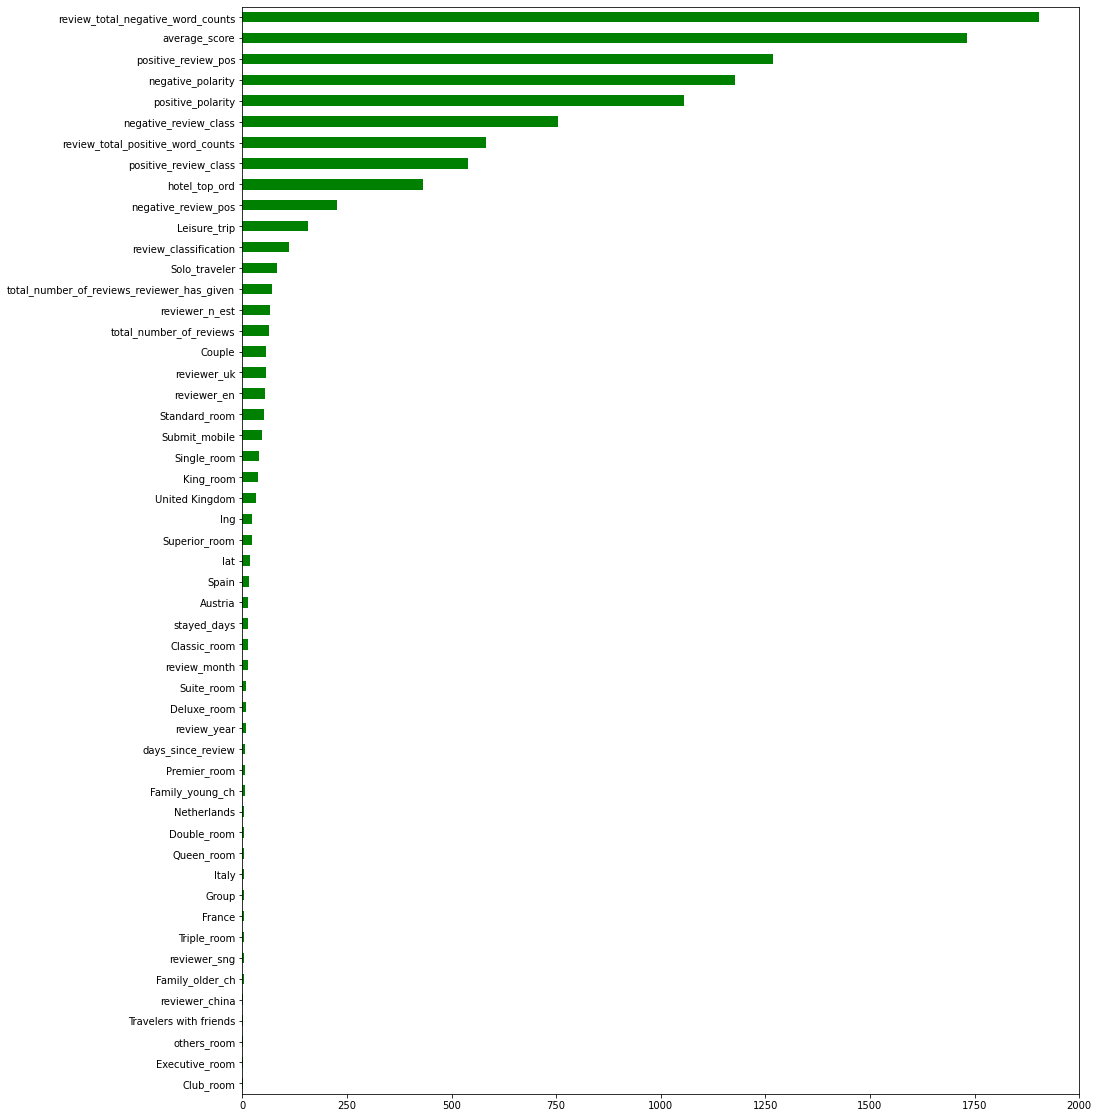

In [42]:
#
y = data.query('sample == 1').drop(['sample'], axis=1).reviewer_score.values
X = data.query('sample == 1').drop(['sample', 'reviewer_score'], axis=1)


# визуализируем результат анализа значимости:
imp_num = pd.Series(f_classif(X[X.columns], y)[0], index = X.columns)
imp_num.sort_values(inplace = True)

fig5, ax5 = plt.subplots(figsize=(15, 20))
imp_num.plot(kind = 'barh', color='green');

удаляем еще 5 признаков: reviewer_china, Travelers_with_friends, other_room, Executive_room, Club_room

In [43]:
# производим удаление
data.drop(['reviewer_china', 'Travelers with friends', 'others_room', 'Executive_room','Club_room'], axis=1, inplace=True)


In [44]:
# Теперь выделим тестовую часть
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample'], axis=1)

y = train_data.reviewer_score.values            # наш таргет
X = train_data.drop(['reviewer_score'], axis=1) # тренеровочные данные с удаленным столбцом рейтингов

In [45]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [46]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((128935, 48), (386803, 48), (386803, 47), (309442, 47), (77361, 47))

In [47]:
# Создаём модель
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [48]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.1min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.3s finished


In [49]:
# сравниваем предсказанные значения (y_pred) с реальными (y_test), 
# метрика Mean Absolute Percentage Error (MAPE) показывает среднюю абсолютную 
# процентную ошибку предсказанных значений от фактических:

def mean_absolute_percentage_error(y_tr, y_pr):
    """Получение средней абсолютной ошибки"""
    y_tr, y_pr = np.array(y_tr), np.array(y_pr)
    return np.mean(np.abs((y_tr - y_pr) / y_tr)) * 100

print('MAPE:', round(mean_absolute_percentage_error(y_test, y_pred), 2))

MAPE: 12.49


оценим вклад важнейших признаков

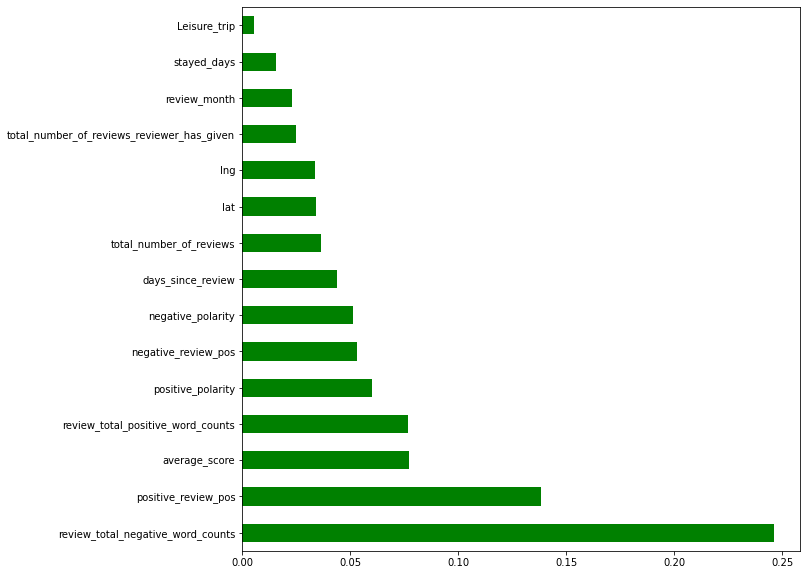

In [50]:
# в RandomForestRegressor есть возможность вывести самые важные признаки
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh', color='green');

Из графика видно, что важнейшие признаки, оказывающие влияние на результат, во многом связаны с отзывами и их анализом. Кроме того, в решающие признаки попали: 
   - средняя оценка (average_score);
   - lat, long;
   - количество дней, проведенных в отеле (stayed_days);
   - путешествие в отпуск (Leisure_trip)

# Предсказания целевой переменной

In [51]:
test_data = test_data.drop(['reviewer_score'], axis=1)
predict_submission = model.predict(test_data)
sample_submission['reviewer_score'] = predict_submission
#
# сохраняем результаты
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    2.2s finished


,reviewer_score,id
0,8.723,488440
1,7.122,274649
2,8.465,374688
3,9.806,404352
4,9.364,451596
5,9.142,302161
6,8.263,317079
7,7.767,13963
8,8.272,159785
9,7.730,195089
